https://blog.yuugakujyuku.com/2023/01/06/kakezantest/

<img src="IMG_7744.jpeg" width=800>

In [1]:
using Distributions
using Printf
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png)

In [2]:
safemul(x, y) = x == 0 ? x : isinf(x) ? oftype(x, Inf) : x*y
safediv(x, y) = x == 0 ? x : isinf(y) ? zero(y) : x/y

x ⪅ y = x < y || x ≈ y

mypdf(dist, x) = pdf(dist, x)
mypdf(dist::DiscreteUnivariateDistribution, x) = pdf(dist, round(Int, x))

distname(dist::Distribution) = replace(string(dist), r"{.*}" => "")
myskewness(dist) = skewness(dist)
mykurtosis(dist) = kurtosis(dist)
function standardized_moment(dist::ContinuousUnivariateDistribution, m)
    μ, σ = mean(dist), std(dist)
    quadgk(x -> (x - μ)^m * pdf(dist, x), extrema(dist)...)[1] / σ^m
end
myskewness(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 3)
mykurtosis(dist::MixtureModel{Univariate, Continuous}) =
    standardized_moment(dist, 4) - 3

mykurtosis (generic function with 2 methods)

In [3]:
_riskratiohat(a, b, c, d) = safediv(a*(c+d), (a+b)*c)

function Delta(a, b, c, d; ρ=1.0)
    m, n = a+b, c+d
    A, B, C = ρ-1, n-a+ρ*(m-c), a*n-ρ*m*c
    Δ = isinf(ρ) ? oftype(ρ, -c) : ρ==0 ? oftype(ρ, a) : safediv(2C, B + √(B^2 - 4A*C))
end

function _chisqstat_rr(a, b, c, d, Δ)
    m, n = a+b, c+d
    safemul(Δ^2, safediv(b, m*(a-Δ)) + safediv(d, n*(c+Δ)))
end

function chisqstat_rr(a, b, c, d; ρ=1.0)
    Δ = Delta(a, b, c, d; ρ)
    _chisqstat_rr(a, b, c, d, Δ)
end

function pvalue_rr_pearson_chisq(a, b, c, d; ρ=1.0)
    χ² = chisqstat_rr(a, b, c, d; ρ)
    ccdf(Chisq(1), χ²)
end

function confint_rr_pearson_chisq(a, b, c, d; α=0.05)
    (a+b==0 || c+d==0 || a+c==0 || b+d==0) && return [0.0, Inf]
    f(logρ) = logit(pvalue_rr_pearson_chisq(a, b, c, d; ρ=exp(logρ))) - logit(α)
    L = if f(-Inf) > 0
        -Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat - 1
        find_zero(f, x0)
    end
    U = if f(Inf) > 0
        Inf
    else
        logRRhat = log(_riskratiohat(a, b, c, d))
        x0 = logRRhat == -Inf ? -10.0 : logRRhat == Inf ? 10.0 : logRRhat + 1
        find_zero(f, x0)
    end
    [exp(L), exp(U)]
end

confint_rr_pearson_chisq (generic function with 1 method)

In [4]:
_data = [
    75 64
    40 72
    75 72
    73 80
    59 72
    19 40
    66 72
    38 44
]
mean(_data; dims=1)

1×2 Matrix{Float64}:
 55.625  64.5

In [5]:
_data = 0.01 * _data .* [73 25]

8×2 Matrix{Float64}:
 54.75  16.0
 29.2   18.0
 54.75  18.0
 53.29  20.0
 43.07  18.0
 13.87  10.0
 48.18  18.0
 27.74  11.0

In [6]:
_data = round.(Int, _data)

8×2 Matrix{Int64}:
 55  16
 29  18
 55  18
 53  20
 43  18
 14  10
 48  18
 28  11

In [7]:
data = [_data[:,2] (25 .- _data[:,2]) _data[:,1] (73 .- _data[:,1])]

8×4 Matrix{Int64}:
 16   9  55  18
 18   7  29  44
 18   7  55  18
 20   5  53  20
 18   7  43  30
 10  15  14  59
 18   7  48  25
 11  14  28  45

In [8]:
for (i, A) in enumerate(eachrow(data))
    print("Problem $i:  data = ", A)
    @printf(",  P-value of RR=1 = %.2f%%", 100pvalue_rr_pearson_chisq(A...))
    @printf(",  95%% CI of RR = [%.3f, %.3f]\n", confint_rr_pearson_chisq(A...)...)
end

Problem 1:  data = [16, 9, 55, 18],  P-value of RR=1 = 27.33%,  95% CI of RR = [0.580, 1.118]
Problem 2:  data = [18, 7, 29, 44],  P-value of RR=1 = 0.53%,  95% CI of RR = [1.211, 2.612]
Problem 3:  data = [18, 7, 55, 18],  P-value of RR=1 = 74.07%,  95% CI of RR = [0.682, 1.216]
Problem 4:  data = [20, 5, 53, 20],  P-value of RR=1 = 46.40%,  95% CI of RR = [0.818, 1.373]
Problem 5:  data = [18, 7, 43, 30],  P-value of RR=1 = 24.37%,  95% CI of RR = [0.854, 1.632]
Problem 6:  data = [10, 15, 14, 59],  P-value of RR=1 = 3.67%,  95% CI of RR = [1.047, 3.971]
Problem 7:  data = [18, 7, 48, 25],  P-value of RR=1 = 56.54%,  95% CI of RR = [0.773, 1.431]
Problem 8:  data = [11, 14, 28, 45],  P-value of RR=1 = 61.88%,  95% CI of RR = [0.650, 1.869]


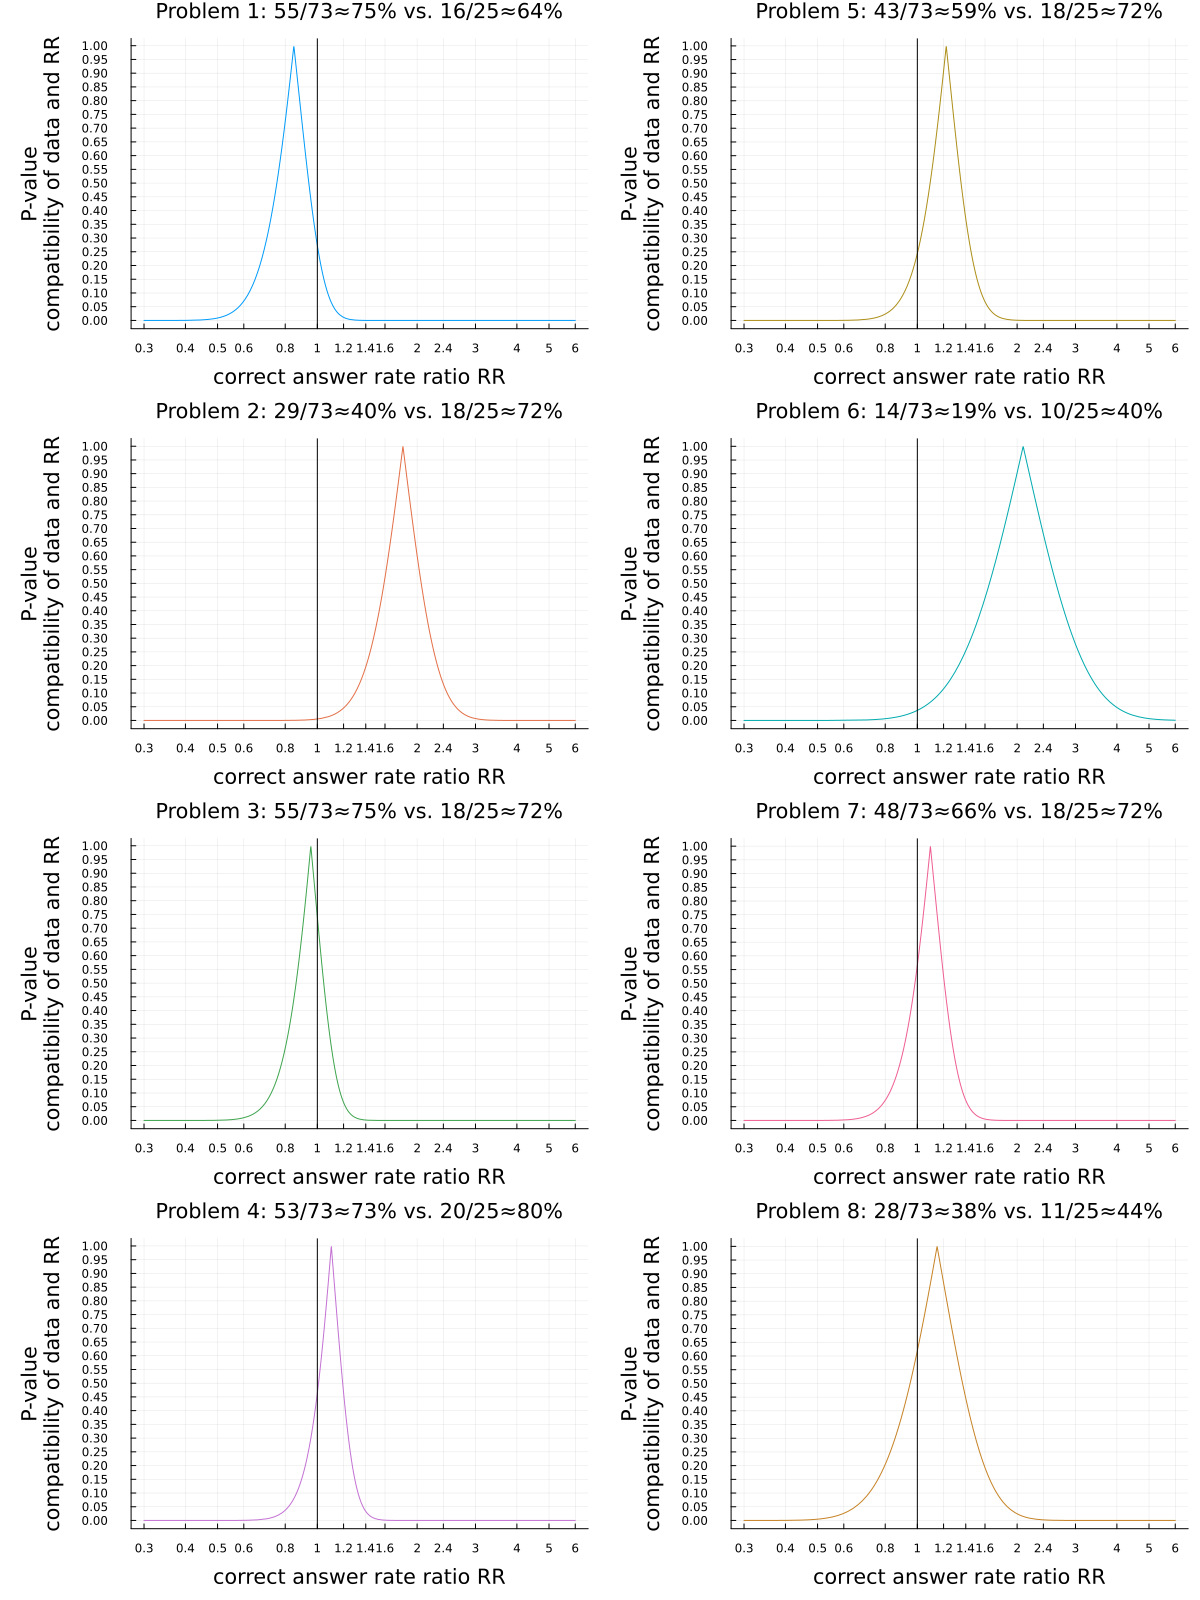

In [9]:
PP = []
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    RR1 = round(Int, 100a/(a+b))
    RR2 = round(Int, 100c/(c+d))
    P = plot(ρ ->pvalue_rr_pearson_chisq(A...; ρ), 0.3, 6; label="", c=i)
    vline!([1]; label="", c=:black)
    plot!(xscale=:log10)
    xtick = Any[0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2, 2.4, 3, 4, 5, 6]
    xtick =(xtick, string.(xtick))
    plot!(; xtick, ytick=0:0.05:1)
    plot!(xguide="correct answer rate ratio RR", 
        yguide="P-value\ncompatibility of data and RR")
    title!("Problem $i: $c/$(c+d)≈$(RR2)% vs. $a/$(a+b)≈$(RR1)%")
    push!(PP, P)
end

plot((isodd(i) ? PP[i÷2+1] : PP[i÷2+4] for i in 1:8)...; size=(1200, 1600), layout=(4, 2))
plot!(leftmargin=10Plots.mm)
plot!(guidefontsize=14)

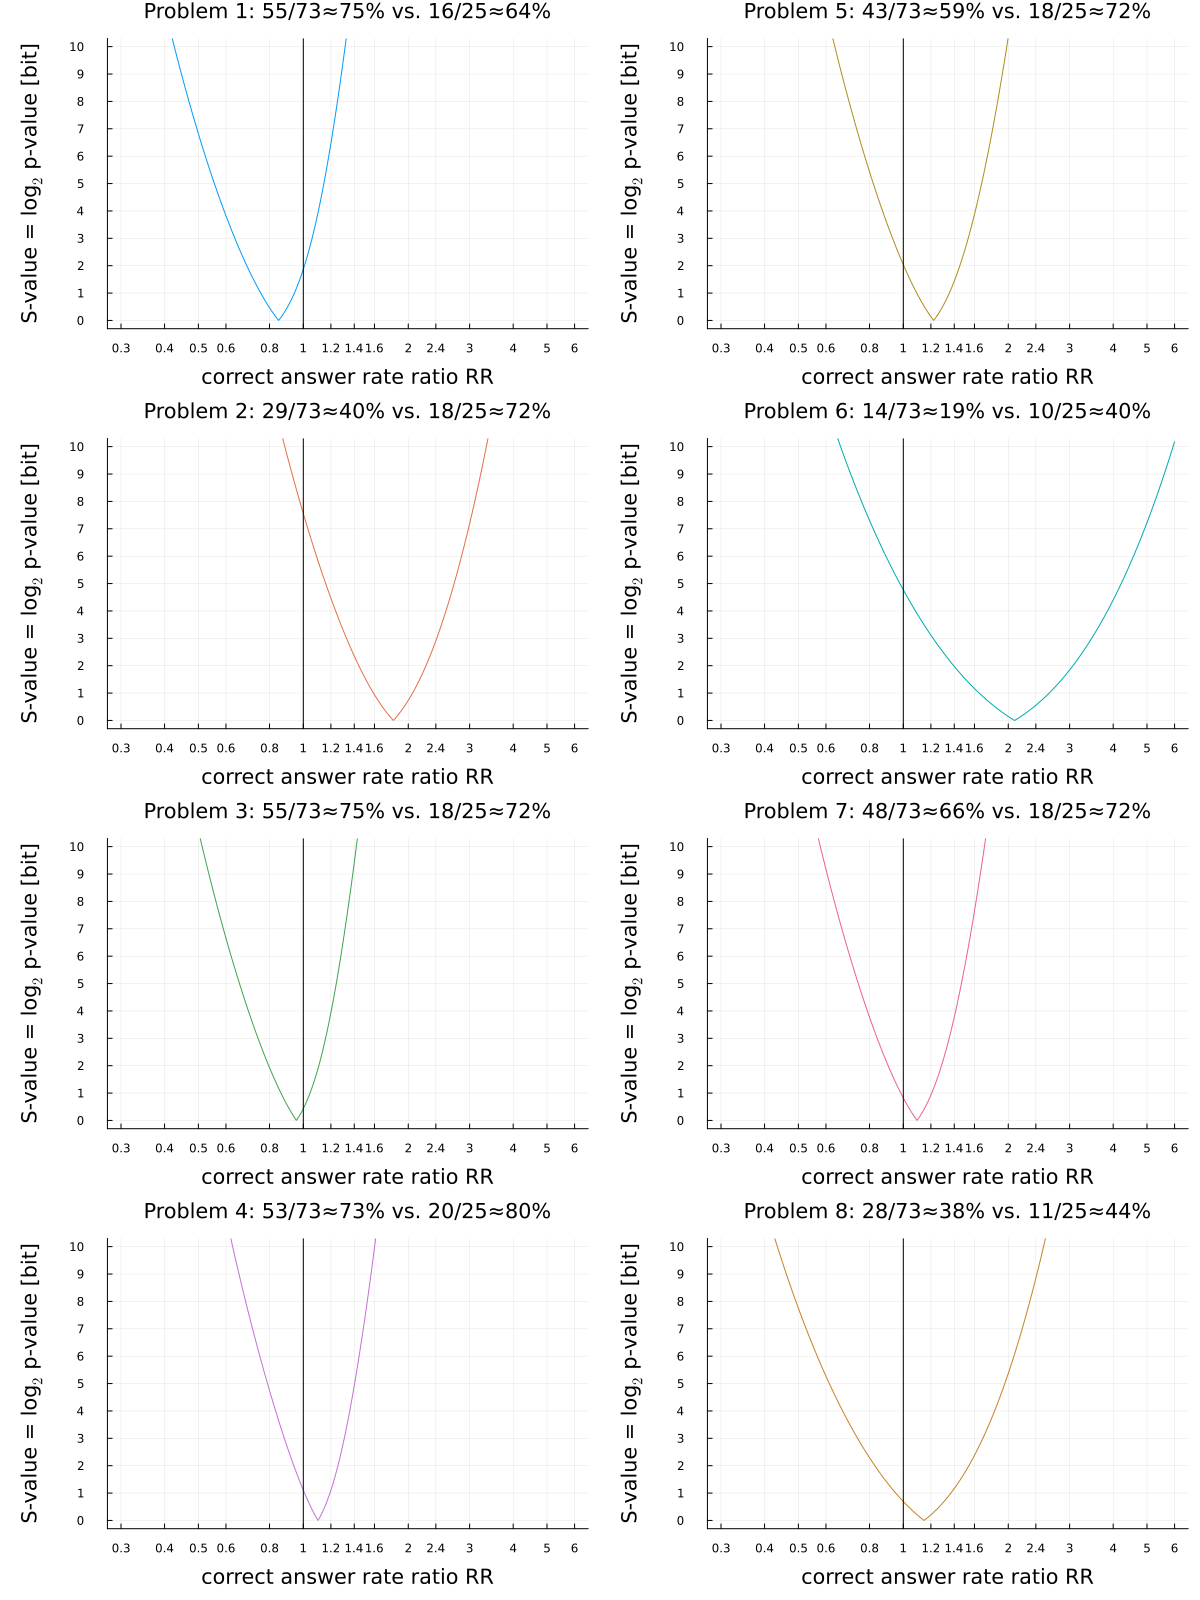

In [10]:
PP = []
for (i, A) in enumerate(eachrow(data))
    a, b, c, d = A
    RR1 = round(Int, 100a/(a+b))
    RR2 = round(Int, 100c/(c+d))
    ρs = 10.0 .^ range(log10(0.3), log10(6), 1000)
    P = plot(ρs, ρ ->-log2(pvalue_rr_pearson_chisq(A...; ρ)); label="", c=i)
    vline!([1]; label="", c=:black)
    plot!(xscale=:log10)
    xtick = Any[0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2, 2.4, 3, 4, 5, 6]
    xtick =(xtick, string.(xtick))
    plot!(; xtick)
    plot!(ylim=(-0.3, 10.3), ytick=0:10)
    plot!(xguide="correct answer rate ratio RR", 
        yguide="S-value = log\${}_2\$ p-value [bit]")
    title!("Problem $i: $c/$(c+d)≈$(RR2)% vs. $a/$(a+b)≈$(RR1)%")
    push!(PP, P)
end

plot((isodd(i) ? PP[i÷2+1] : PP[i÷2+4] for i in 1:8)...; size=(1200, 1600), layout=(4, 2))
plot!(leftmargin=12Plots.mm)
plot!(guidefontsize=14)